## Практическое задание к уроку № 6 по теме "Задача look-alike".

1. Взять любой набор данных для бинарной классификации
2. Обучить любой классификатор (какой вам нравится)
3. Разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные примеры (класс 1), а только лишь часть
4. Применить random negative sampling для построения классификатора в новых условиях
5. Сравнить качество с решением из пункта 3 (построить отчет - таблицу метрик)
6. *Поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
# from sklearn.preprocessing import StandardScaler

Возьмём датасет для бинарной классификации цитрусов, является ли цитрус апельсином или грейпфрутом.  
https://www.kaggle.com/datasets/joshmcadams/oranges-vs-grapefruit

In [2]:
df = pd.read_csv('citrus.csv')
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [3]:
df.describe()

,diameter,weight,red,green,blue
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,9.975685,175.050792,153.847800,76.010600,11.363200
std,1.947844,29.212119,10.432954,11.708433,9.061275
min,2.960000,86.760000,115.000000,31.000000,2.000000
25%,8.460000,152.220000,147.000000,68.000000,2.000000
50%,9.980000,174.985000,154.000000,76.000000,10.000000
75%,11.480000,197.722500,161.000000,84.000000,17.000000
max,16.450000,261.510000,192.000000,116.000000,56.000000


In [4]:
TARGET = 'name'

In [5]:
df[TARGET].value_counts()

orange        5000
grapefruit    5000
Name: name, dtype: int64

Небаланса классов нет.

Апельсины обозначим за класс 1, грейпфруты - за класс 0:

In [6]:
df[TARGET] = df[TARGET].map({'orange': 1, 'grapefruit': 0})

Обучим обычную модель классификации с отложенной выборкой:

In [7]:
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [8]:
cols = ['diameter', 'weight', 'red', 'green', 'blue']

In [9]:
final_transformers = []

for col in cols:
    col_transformer = Pipeline([
        ('selector', NumberSelector(key=col)),
        # ('scaler', StandardScaler())
    ])
    
    final_transformers.append((col, col_transformer))

In [10]:
feats = FeatureUnion(final_transformers)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, df[TARGET], test_size=0.25, random_state=29)

In [12]:
gb_model = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=29))
])

In [13]:
gb_model.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

Оценим её качество. Не будем брать метрики precision и recall, заменим их на  
accuracy, в данном случае она должна быть представительной, ведь у нас  
нет небаланса классов.

In [14]:
def evaluate_results(y_true, y_pred, verbose=True):
    
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    if verbose:
        print(f'F1-score:\t{f1:.2f}\n'
              f'Accuracy:\t{acc:.2f}')

    return f1, acc

In [15]:
class_f1, class_accuracy = evaluate_results(y_test, y_pred)

F1-score:	0.95
Accuracy:	0.94


Теперь воспользуемся random negative sampling и выберем только часть  
объектов положительного класса. Далее случайно выберем столько же объектов  
из того, что осталось, и пометим их как отрицательный класс. На выбранных  
таким образом объектах проведём обучение, а на оставшихся - посчитаем метрики.  
Долю размеченных данных положительного класса сначала возьмём 25%:

In [16]:
def pu_teach(frac=0.25, verbose=True, show_fractions=True):
    
    np.random.seed(29)
    mod_df = df.copy()
    
    # get the indices of the positives samples
    pos_ind = np.where(mod_df[TARGET].values == 1)[0]

    # shuffle them
    np.random.shuffle(pos_ind)
    # leave frac% of the positives marked
    pos_sample_len = int(np.ceil(frac * len(pos_ind)))

    if show_fractions:
        print(f'Frac = {frac}: Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest\n')
    pos_sample = pos_ind[:pos_sample_len]
    mod_df['class_test'] = 0
    mod_df.loc[pos_sample, 'class_test'] = 1
    mod_df = mod_df.sample(frac=1)
    
    data_N = mod_df[mod_df['class_test'] == 0]
    data_P = mod_df[mod_df['class_test'] == 1]
    
    neg_sample = data_N[:data_P.shape[0]]
    sample_test = data_N[data_P.shape[0]:]
    pos_sample = data_P.copy()
    
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    gb_model.fit(sample_train.drop(['class_test', TARGET], axis=1), sample_train['class_test'])
    preds = gb_model.predict(sample_test.drop(['class_test', TARGET], axis=1))
    
    return evaluate_results(sample_test[TARGET], preds, verbose)

In [17]:
pu_learn_f1, pu_learn_acc = pu_teach()

Frac = 0.25: Using 1250/5000 as positives and unlabeling the rest

F1-score:	0.89
Accuracy:	0.91


Сравним эти метрики с теми, что получились при обучении на отложенной выборке  
при обычной классификации:

In [18]:
methods = ['Classification', 'PU-learning']
columns = ['F1-score', 'Accuracy']
data = np.array([
    [class_f1, class_accuracy], 
    [pu_learn_f1, pu_learn_acc]
])
pd.DataFrame(data, index=methods, columns=columns)

,F1-score,Accuracy
Classification,0.945020,0.944800
PU-learning,0.893922,0.911333


Обычная классификация оказалась лучше, так как метки классов всей  
обучающей выборки были известны модели при обучении. Также сама  
обучающая выборка имела достаточный размер.  
Посмотрим, как будут вести себя метрики при изменении доли размеченных  
данных позитивного класса:

Frac = 0.1: Using 500/5000 as positives and unlabeling the rest

Frac = 0.2: Using 1000/5000 as positives and unlabeling the rest

Frac = 0.30000000000000004: Using 1501/5000 as positives and unlabeling the rest

Frac = 0.4: Using 2000/5000 as positives and unlabeling the rest

Frac = 0.5: Using 2500/5000 as positives and unlabeling the rest

Frac = 0.6: Using 3000/5000 as positives and unlabeling the rest

Frac = 0.7000000000000001: Using 3501/5000 as positives and unlabeling the rest

Frac = 0.8: Using 4000/5000 as positives and unlabeling the rest

Frac = 0.9: Using 4500/5000 as positives and unlabeling the rest



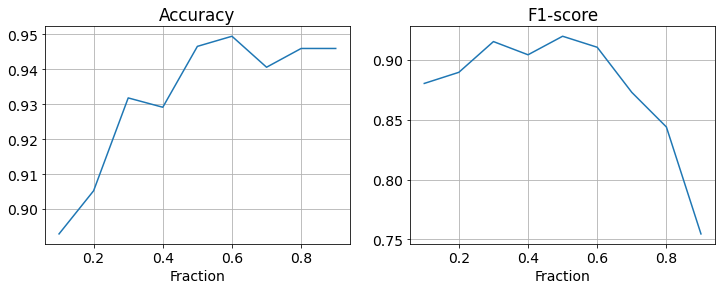

In [19]:
P_frac = np.linspace(0.1, 0.9, 9)
acc_scores = []
f1_scores = []

for frac in P_frac:
    acc_scores.append(pu_teach(frac=frac, verbose=False)[1])
    f1_scores.append(pu_teach(frac=frac, verbose=False, show_fractions=False)[0])

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(P_frac, acc_scores)
ax1.set_xlabel('Fraction')
ax1.set_title('Accuracy')
ax1.grid()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(P_frac, f1_scores)
ax2.set_xlabel('Fraction')
ax2.set_title('F1-score')
ax2.grid()

plt.show()

Оптимальное значение доли размеченных данных позитивного класса оказалось  
примерно 0,5-0,6. При этом у нас самые высокие значения метрик. Падение  
F1-score при увеличении доли выше 0,6, скорее всего, связано с переобучением  
модели из-за большого размера обучающей выборки и малого размера тестовой  
выборки.